In [1]:
import math
from graphviz import Digraph

def trace(root):
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot= Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name= uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data= data
        self.grad= 0.0
        self._prev= set(_children)
        self._op= _op
        self.label= label
        self._backward= lambda: None

    def __repr__(self):
        return f"Value(data= {self.data})"

    def __add__(self, other):
        other= other if isinstance(other,Value) else Value(other)
        out= Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward= _backward
        return out

    def __radd__(self,other):
        return self + other

    def __mul__(self, other):
        other= other if isinstance(other,Value) else Value(other)
        out= Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward= _backward
        return out

    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
        other= other if isinstance(other,Value) else Value(other)
        out= Value(self.data / other.data,(self,other),'/')
        def _backward():
            self.grad += out.grad * 1.0 / other.data
            other.grad += out.grad * -1.0 * self.data / (other.data**2)
        out._backward= _backward
        return out


    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other= other if isinstance(other,Value) else Value(other)
        out= Value(self.data - other.data,(self,other),'-')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * -1.0
        out._backward= _backward
        return out

    def __pow__(self,other):
       other= other if isinstance(other,Value) else Value(other)
       out= Value(self.data**other.data,(self,other),'**')
       def _backward():
           self.grad += out.grad * other.data
           other.grad += out.grad * self.data * math.log(self.data) * (other.data**2)
       out._backward= _backward

    def exp(self):
        x= self.data
        out= Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward= _backward
        return out


    def tanh(self):
        x= self.data
        t= (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out= Value(t, (self,), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward= _backward
        return out

    def backward(self):
        back= []
        self.grad= 1;
        self._backward()
        for child in self._prev:
            back.append(child)
        while len(back) > 0:
            back[0]._backward()
            for child in back[0]._prev:
              if child not in back:
                back.append(child)
            back= back[1:]

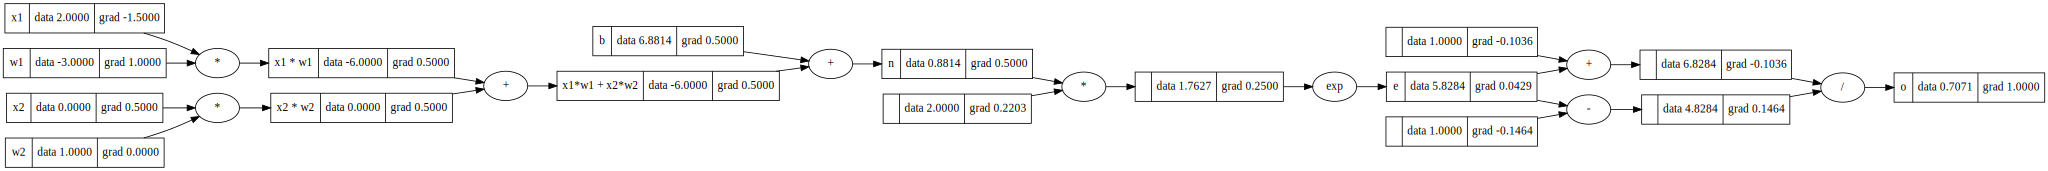

In [2]:
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
b= Value(6.8813735870195432, label='b')
x1w1= x1 * w1; x1w1.label= 'x1 * w1'
x2w2= x2 * w2; x2w2.label= 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label= 'n'
e= (2*n).exp(); e.label= 'e'
o= (e-1)/(e+1); o.label= 'o';
o.backward()
draw_dot(o)